# 01 Upstream QC

In [1]:
from libraries import *
from parameters import *

In [2]:
%load_ext rpy2.ipython

In [3]:
os.getcwd()
os.chdir(projectDir)

## Parameters

In [4]:
conf_mt_prefix = 'MT-' if par_species == 'human' else 'mt-'

***

## Read the sample sheet and data sets

In [5]:
conf_sample_sheet = pd.read_csv(Path(par_data_dir) / 'samples.csv').set_index('h5ad_or_h5_path')
conf_sample_sheet

sample_name   raw round  channel
h5ad_or_h5_path                                 
E3-1-raw.h5            E3-1  True    E3        1
E3-2-raw.h5            E3-2  True    E3        2
E3-3-raw.h5            E3-3  True    E3        3
E3-4-raw.h5            E3-4  True    E3        4
E3-5-raw.h5            E3-5  True    E3        5
E3-6-raw.h5            E3-6  True    E3        6
E3-7-raw.h5            E3-7  True    E3        7
E3-8-raw.h5            E3-8  True    E3        8
E3-9-raw.h5            E3-9  True    E3        9
E3-10-raw.h5          E3-10  True    E3       10
E3-11-raw.h5          E3-11  True    E3       11
E3-12-raw.h5          E3-12  True    E3       12
E3-13-raw.h5          E3-13  True    E3       13
E3-14-raw.h5          E3-14  True    E3       14
E3-15-raw.h5          E3-15  True    E3       15
E3-16-raw.h5          E3-16  True    E3       16
E3-17-raw.h5          E3-17  True    E3       17
E3-18-raw.h5          E3-18  True    E3       18
E3-19-raw.h5          E3-19  True    E3       19
E3-20-raw.h5          E3-20  True    E3       20
E3-21-raw.h5          E3-21  True    E3       21
E3-22-raw.h5          E3-22  True    E3       21
E3-23-raw.h5          E3-23  True    E3       23
E3-24-raw.h5          E3-24  True    E3       24
E4-1-raw.h5            E4-1  True    E4        1
E4-2-raw.h5            E4-2  True    E4        2
E4-3-raw.h5            E4-3  True    E4        3
E4-4-raw.h5            E4-4  True    E4        4
E4-5-raw.h5            E4-5  True    E4        5
E4-6-raw.h5            E4-6  True    E4        6
E4-7-raw.h5            E4-7  True    E4        7
E4-8-raw.h5            E4-8  True    E4        8
E4-9-raw.h5            E4-9  True    E4        9
E4-10-raw.h5          E4-10  True    E4       10
E4-11-raw.h5          E4-11  True    E4       11
E4-12-raw.h5          E4-12  True    E4       12
E4-13-raw.h5          E4-13  True    E4       13
E4-14-raw.h5          E4-14  True    E4       14
E4-15-raw.h5          E4-15  True    E4       15
E4-16-raw.h5          E4-16  True    E4       16
E4-17-raw.h5          E4-17  True    E4       17
E4-19-raw.h5          E4-19  True    E4       19
E4-20-raw.h5          E4-20  True    E4       20
E4-21-raw.h5          E4-21  True    E4       21
E4-22-raw.h5          E4-22  True    E4       22
E4-24-raw.h5          E4-24  True    E4       24

In [6]:
conf_n_samples = len(conf_sample_sheet)

conf_plotting_n_cols = 5
conf_plotting_width = 20
conf_plotting_height_per_row = 3.5

conf_plotting_n_rows = math.ceil(conf_n_samples/conf_plotting_n_cols)
conf_sample_features = conf_sample_sheet.columns.tolist()

In [7]:
assert 'sample_name' in conf_sample_sheet.columns, 'Sample sheet must have a unique sample_name column'
assert 'raw' in conf_sample_sheet.columns, 'Sample sheet must have a raw (True or False) column'
assert conf_sample_sheet.sample_name.nunique() == conf_n_samples, 'Sample sheet must have a unique sample_name column'

## Tools for prefiltered data

In [8]:
# TODO: loading an R package that uses reticulate causes a segfault, see https://github.com/rstudio/reticulate/issues/208
# Seurat 3.1.0 loads leiden package that causes this. Use Seurat 3.0.2 for now.
def soupX(path_list, sample_names, soup_range=(0, 10), keep_droplets=True, n_top_cont_genes=20):

    sx = importr('SoupX')
    scl = sx.load10X(StrVector(path_list),
                     channelNames=StrVector(sample_names),
                     soupRange=FloatVector(soup_range),
                     keepDroplets=keep_droplets)

    scl = sx.inferNonExpressedGenes(scl)
    for sample in sample_names:
        df = scl.rx2('channels').rx2(sample).rx2('nonExpressedGenes')
        cont_genes = df[df.isUseful == 1][:n_top_cont_genes].index.values
        sx_cont_genes = ListVector(dict(c_genes=cont_genes.tolist()))
        scl = sx.calculateContaminationFraction(scl, sample, cont_genes)
        scl = sx.interpolateCellContamination(scl, sample, useGlobal=True)

    return scl

In [11]:
def emptydrops(adata, lower, niters, ignore, retain=None, seed=0, **kwargs):
    r('set.seed')(seed)
    du = importr('DropletUtils')
    ed = du.emptyDrops(adata.X.T,
                       lower=lower,
                       niters=niters,
                       ignore=ignore,
                       retain=retain,
                       **kwargs)
    fdr = r('`[[`')(ed, 'FDR')
    adata.obs['empty_drops_FDR'] = fdr

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        fdr[fdr == 0.0] = 1.0/niters

        adata.obs['neg_log10_empty_drops_FDR'] = -np.log10(fdr)

## Store QC info and run tools on prefiltered data

In [12]:
%%time

conf_samples = {}

for sample in tqdm(list(conf_sample_sheet.itertuples())):
    file = Path(par_data_dir) / sample.Index

    if str(sample.raw).lower() == 'true':
        ad = sc.read_10x_h5(file).copy()
    else:
        ad = sc.read(file)

    ad.var_names_make_unique()
    display(ad)
    

    for sample_feature in conf_sample_features:
        ad.obs[sample_feature] = sample._asdict()[sample_feature]

    if str(sample.raw).lower() == 'true':
        # EmptyDrops
        emptydrops(ad,
                   lower=par_empty_drops_lower_umi_cutoff,
                   niters=par_empty_drops_niters,
                   ignore=par_empty_drops_ignore_cutoff,
                   retain=par_empty_drops_retain)
    else:
        ad.obs['empty_drops_FDR'] = np.nan
        ad.obs['neg_log10_empty_drops_FDR'] = np.nan

    ad.obs['n_umis']  = ad.X.sum(1)
    ad.obs['n_genes'] = (ad.X != 0).sum(1).A1
    ad.obs['log10_n_umis'] = np.log10(ad.X.sum(1))
    ad.obs['log10_n_genes'] = np.log10((ad.X != 0).sum(1).A1)

    # Total UMI/gene cutoffs
    ad = ad[ad.obs.n_umis  > par_initial_umi_cutoff]
    ad = ad[ad.obs.n_genes > par_initial_gene_cutoff]
    display(ad)

    # Save barcode rank
    ad.obs['barcode_rank'] = scipy.stats.rankdata(-ad.obs['n_umis'])

    # MT
    mt_gene_mask = ad.var_names.str.startswith(conf_mt_prefix)
    assert mt_gene_mask.sum() > 0, 'Wrong mt prefix'
    ad.obs['mt_frac'] = ad.X[:, mt_gene_mask].sum(1).A1 / ad.obs['n_umis']

    conf_samples[sample.sample_name] = ad.copy()

  0%|          | 0/46 [00:00<?, ?it/s]

reading data/E3-1-raw.h5
 (0:00:08)


/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6794880 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

PackageNotInstalledError: The R package "DropletUtils" is not installed.

In [11]:
conf_samples

{'E3-1': AnnData object with n_obs × n_vars = 22667 × 31053 
     obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes', 'barcode_rank', 'mt_frac'
     var: 'gene_ids', 'feature_types', 'genome',
 'E3-2': AnnData object with n_obs × n_vars = 23157 × 31053 
     obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes', 'barcode_rank', 'mt_frac'
     var: 'gene_ids', 'feature_types', 'genome',
 'E3-3': AnnData object with n_obs × n_vars = 23149 × 31053 
     obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes', 'barcode_rank', 'mt_frac'
     var: 'gene_ids', 'feature_types', 'genome',
 'E3-4': AnnData object with n_obs × n_vars = 15597 × 31053 
     obs: 'sample_name', 'raw', 'round', 'channel', 'empty_drops_FDR'

## UMI/Gene Rank Plots

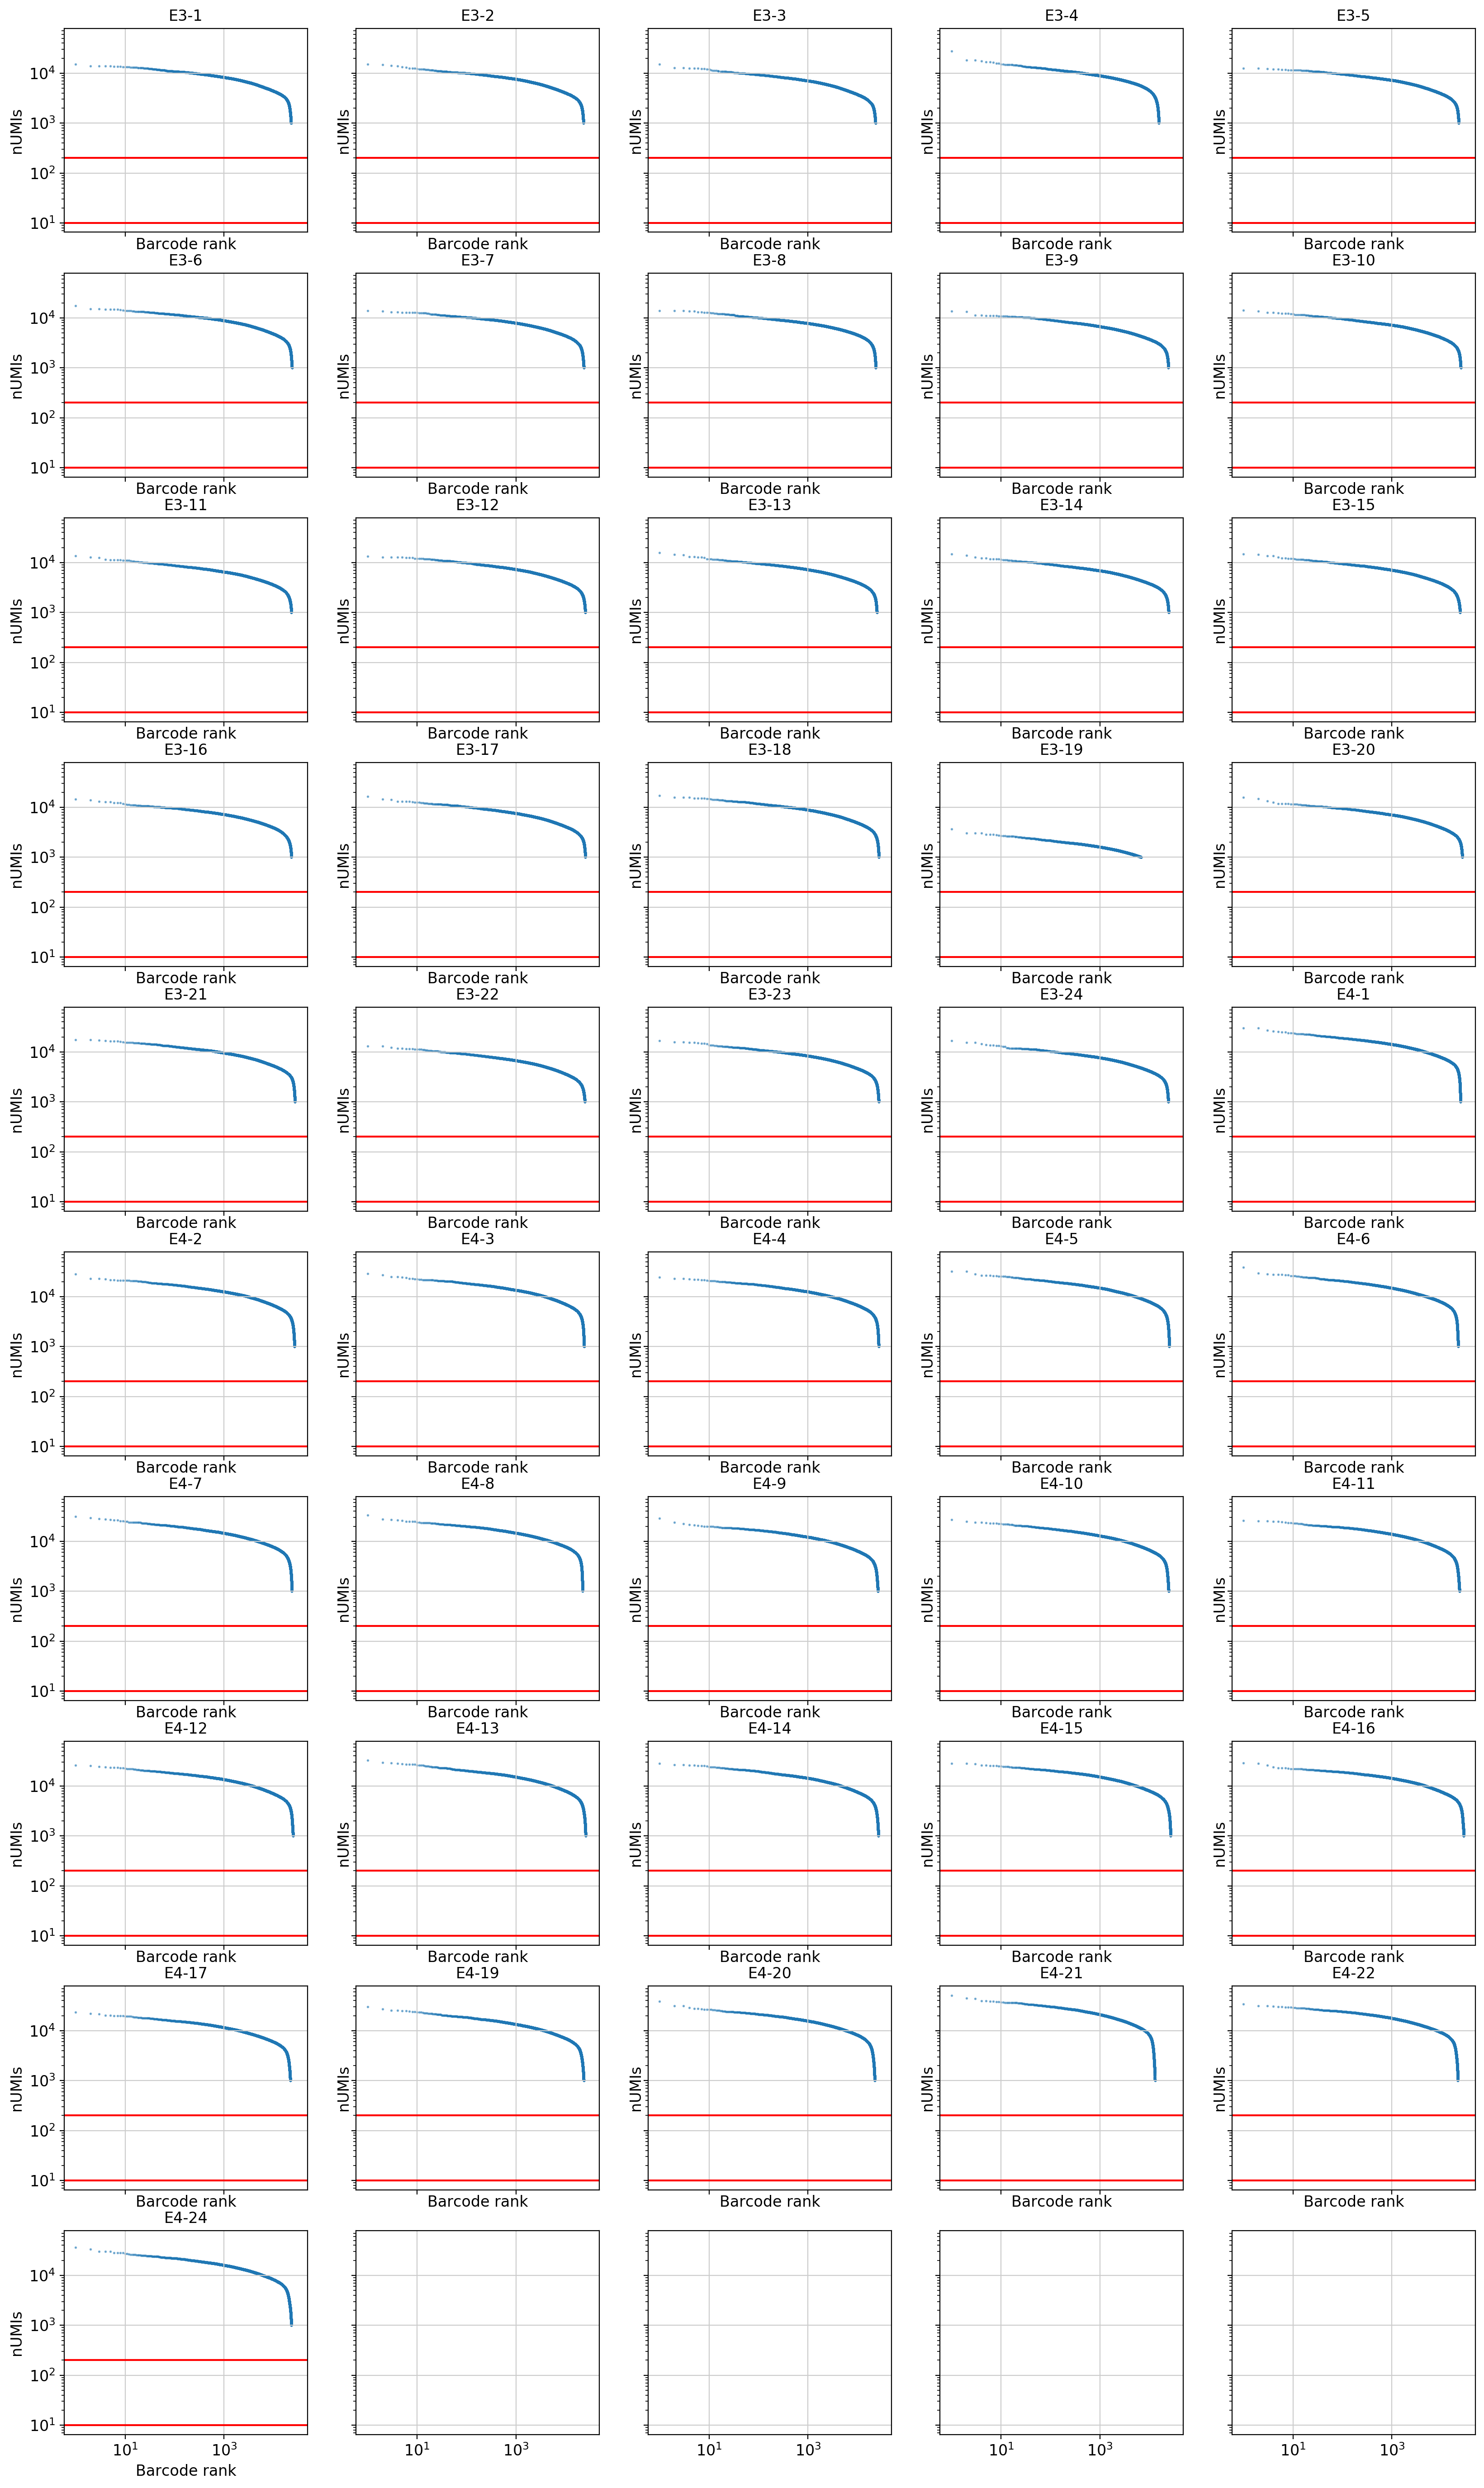

In [12]:
f, axs = plt.subplots(conf_plotting_n_rows, conf_plotting_n_cols,
                      figsize=(conf_plotting_width,
                               conf_plotting_n_rows*conf_plotting_height_per_row),
                      sharey=True, sharex=True)
axs = axs.flatten()

for sample, ad, ax in tqdm(list(zip(conf_samples.keys(), conf_samples.values(), axs))):
    ax.scatter(ad.obs.barcode_rank.values,
               ad.obs.n_umis.values,
               s=1, alpha=0.5)

    ax.axhline(par_empty_drops_ignore_cutoff, color='red')
    ax.axhline(par_empty_drops_lower_umi_cutoff, color='red')

    ax.set_yscale('log')
    ax.set_xscale('log')

    ax.set_xlabel('Barcode rank')
    ax.set_ylabel('nUMIs')

    ax.set_title(sample)

plt.subplots_adjust()

## nGenes vs nUMIs and distributions

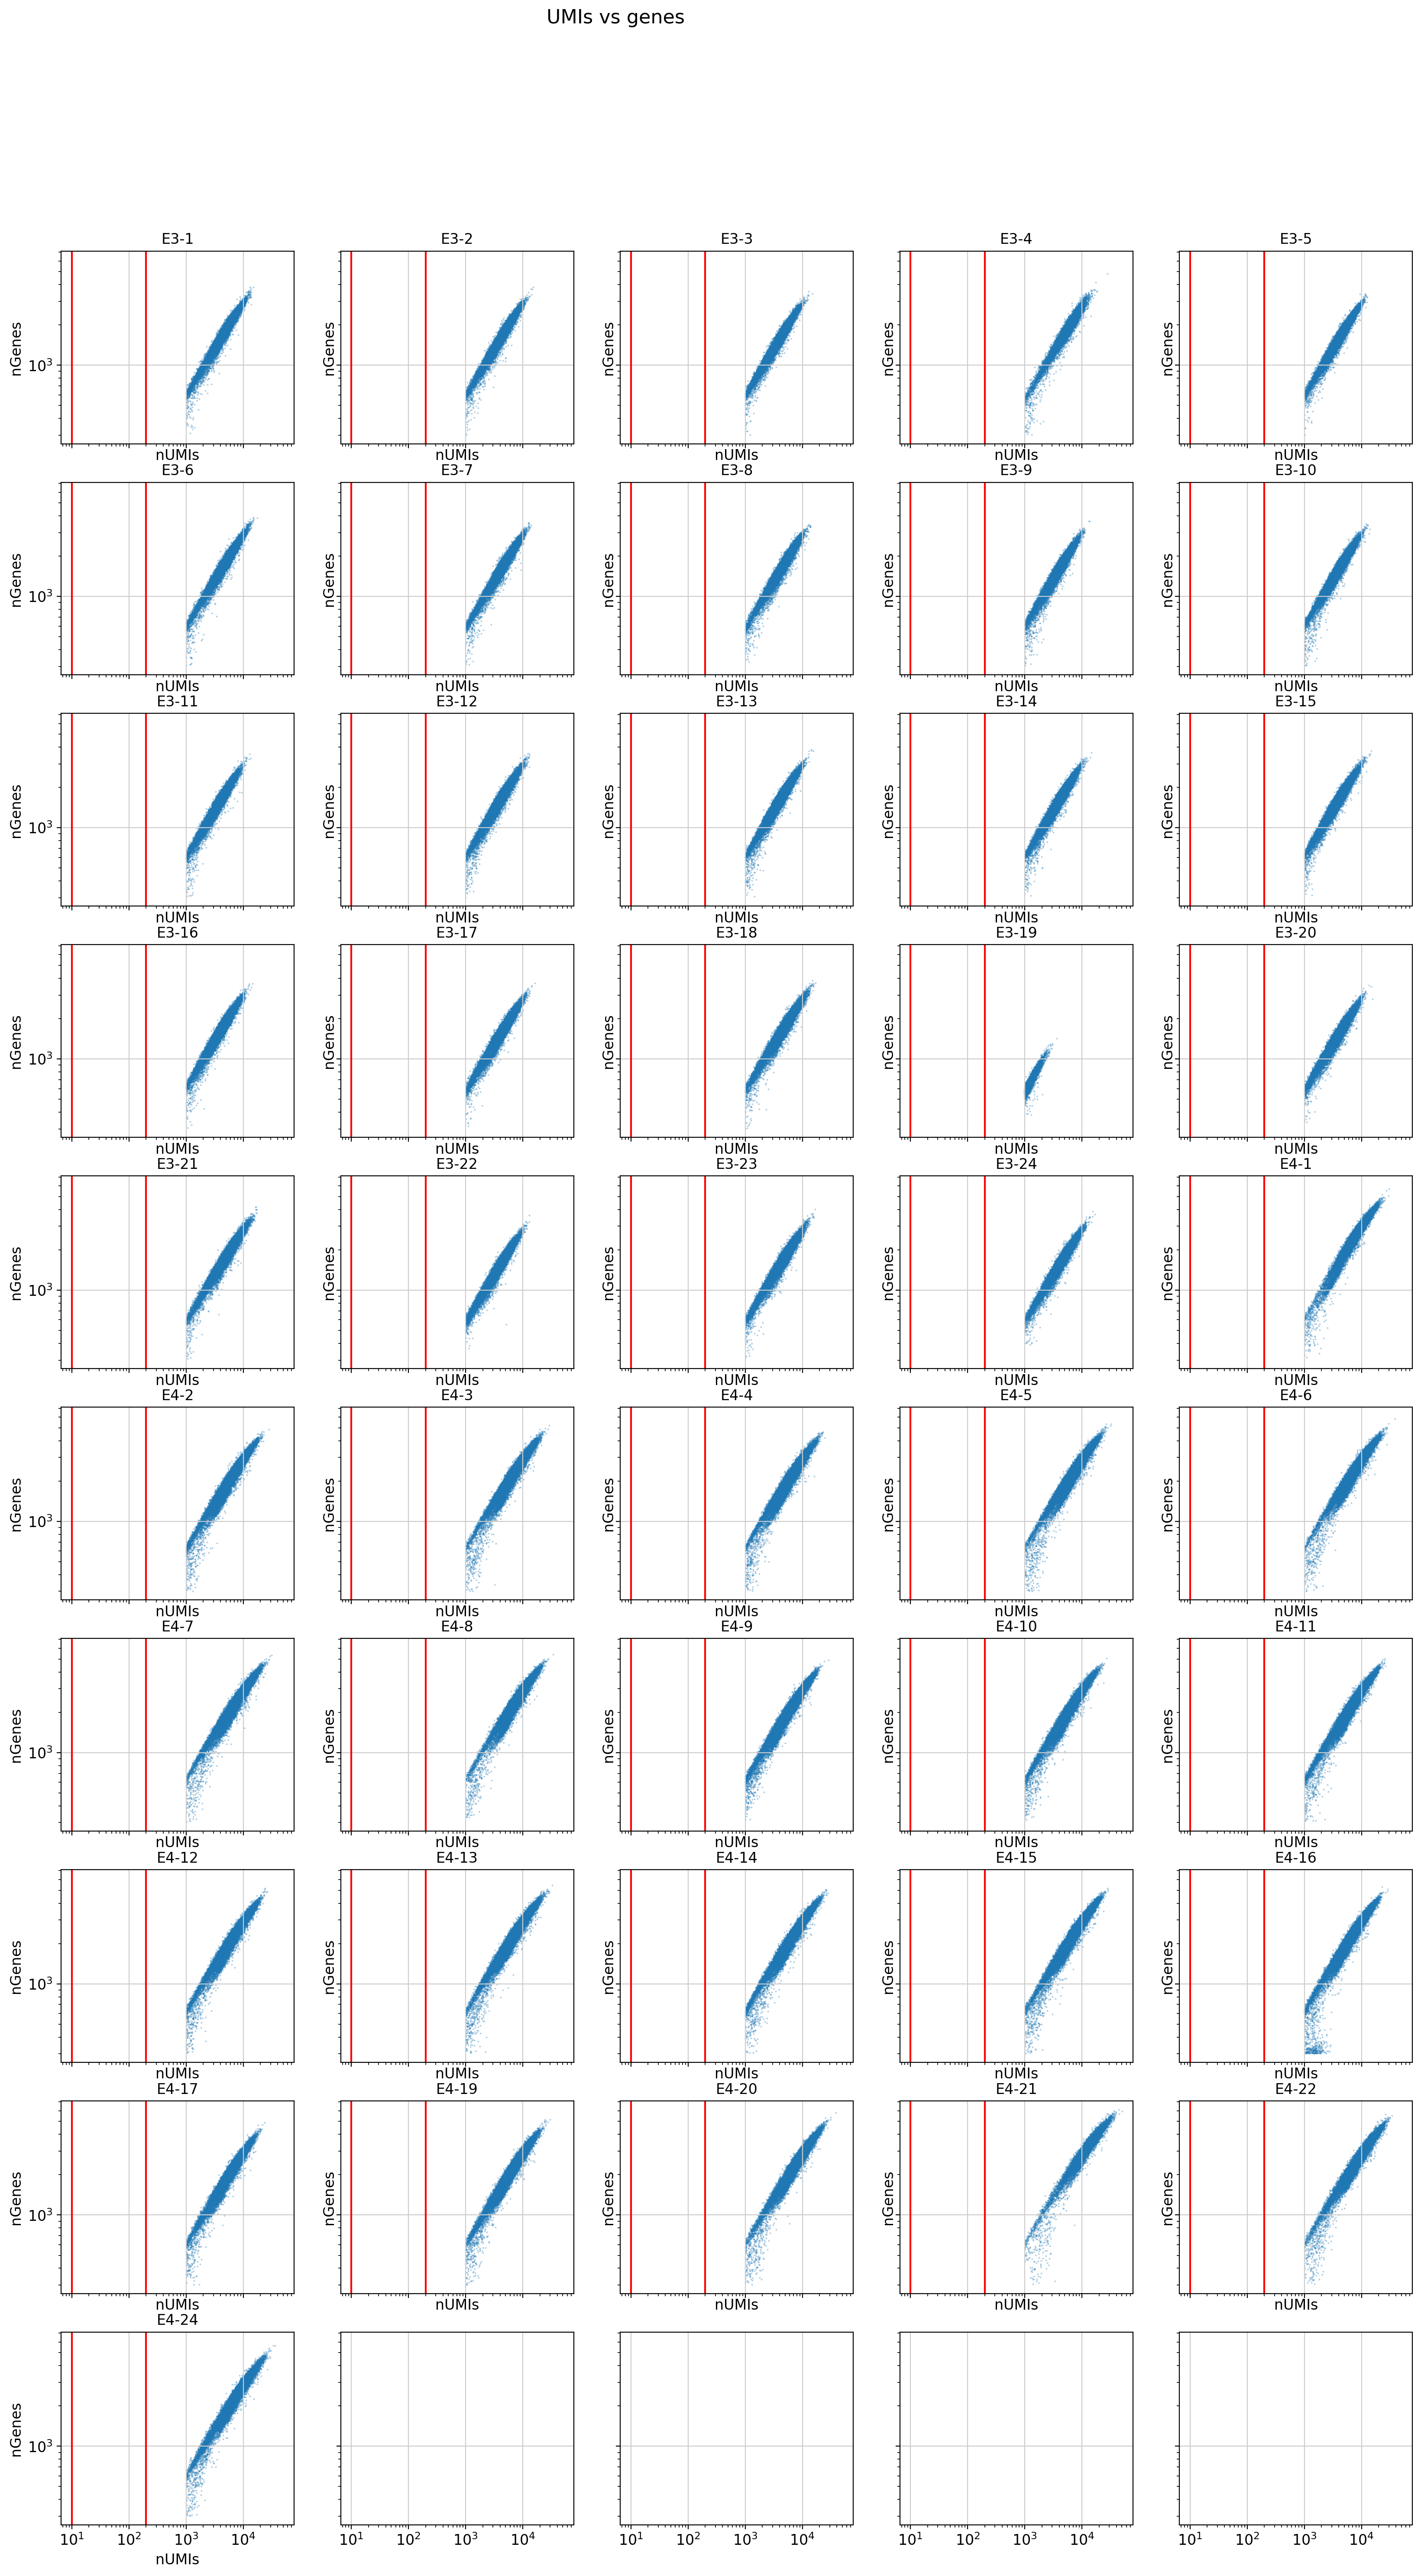

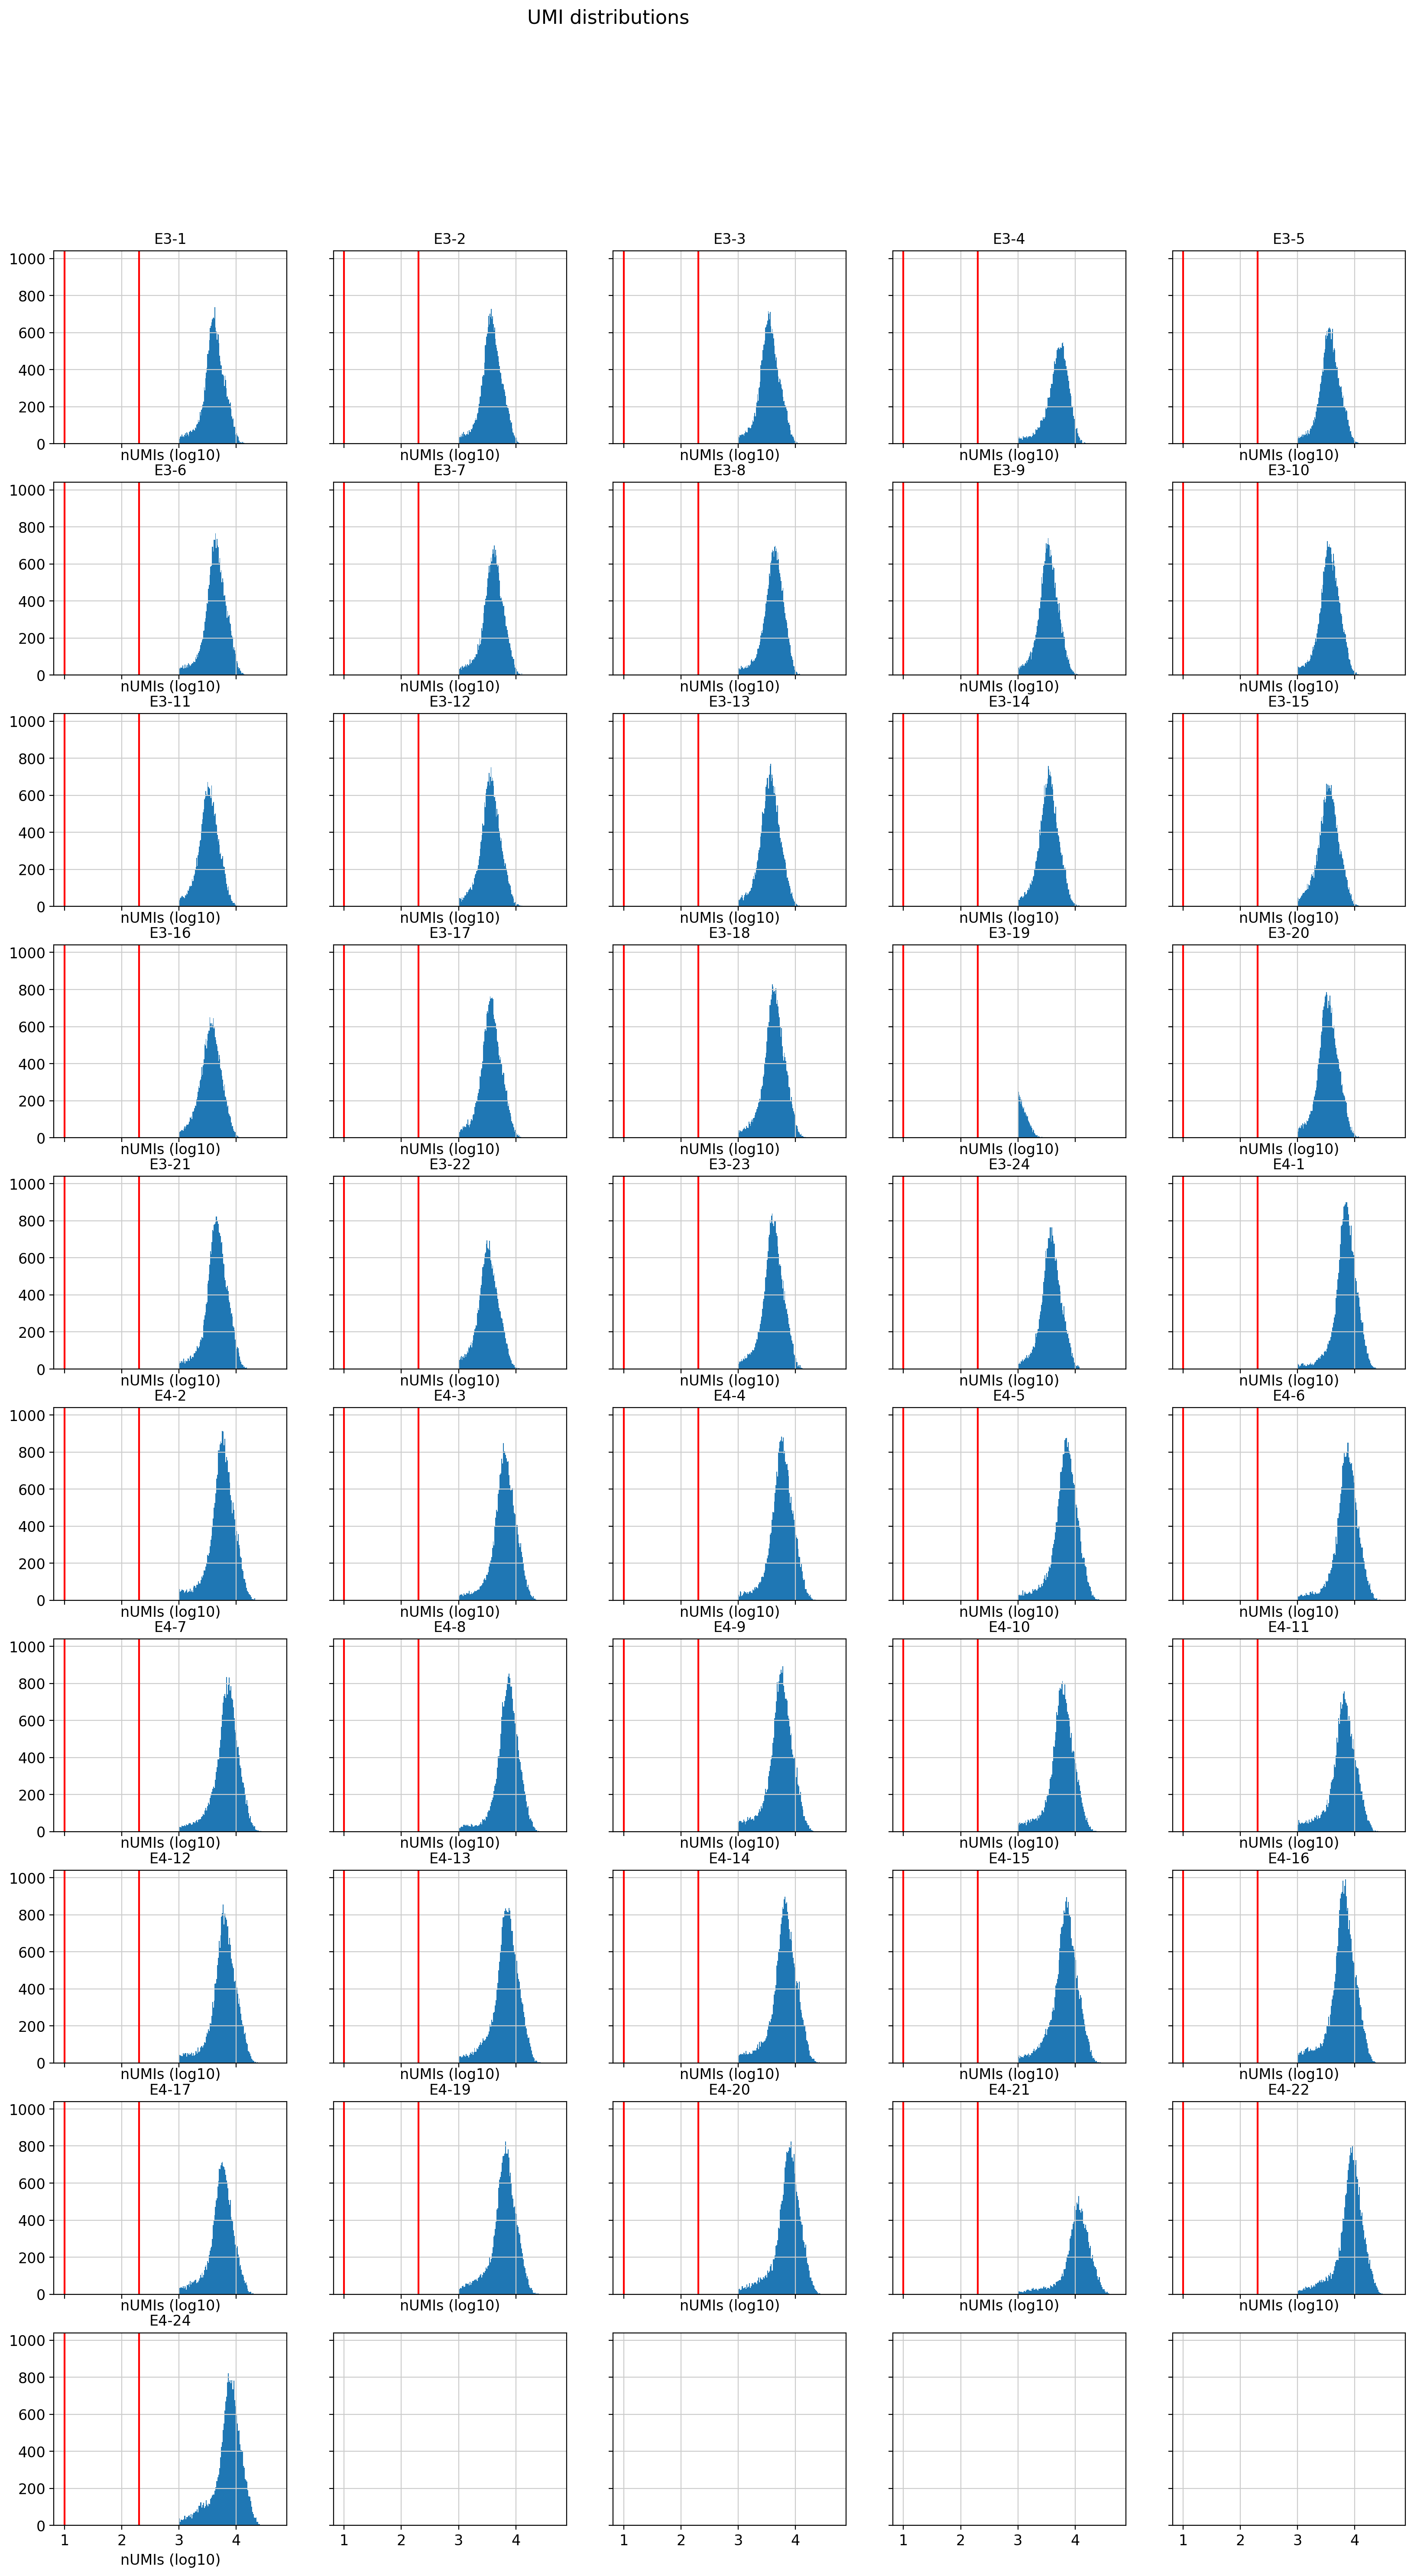

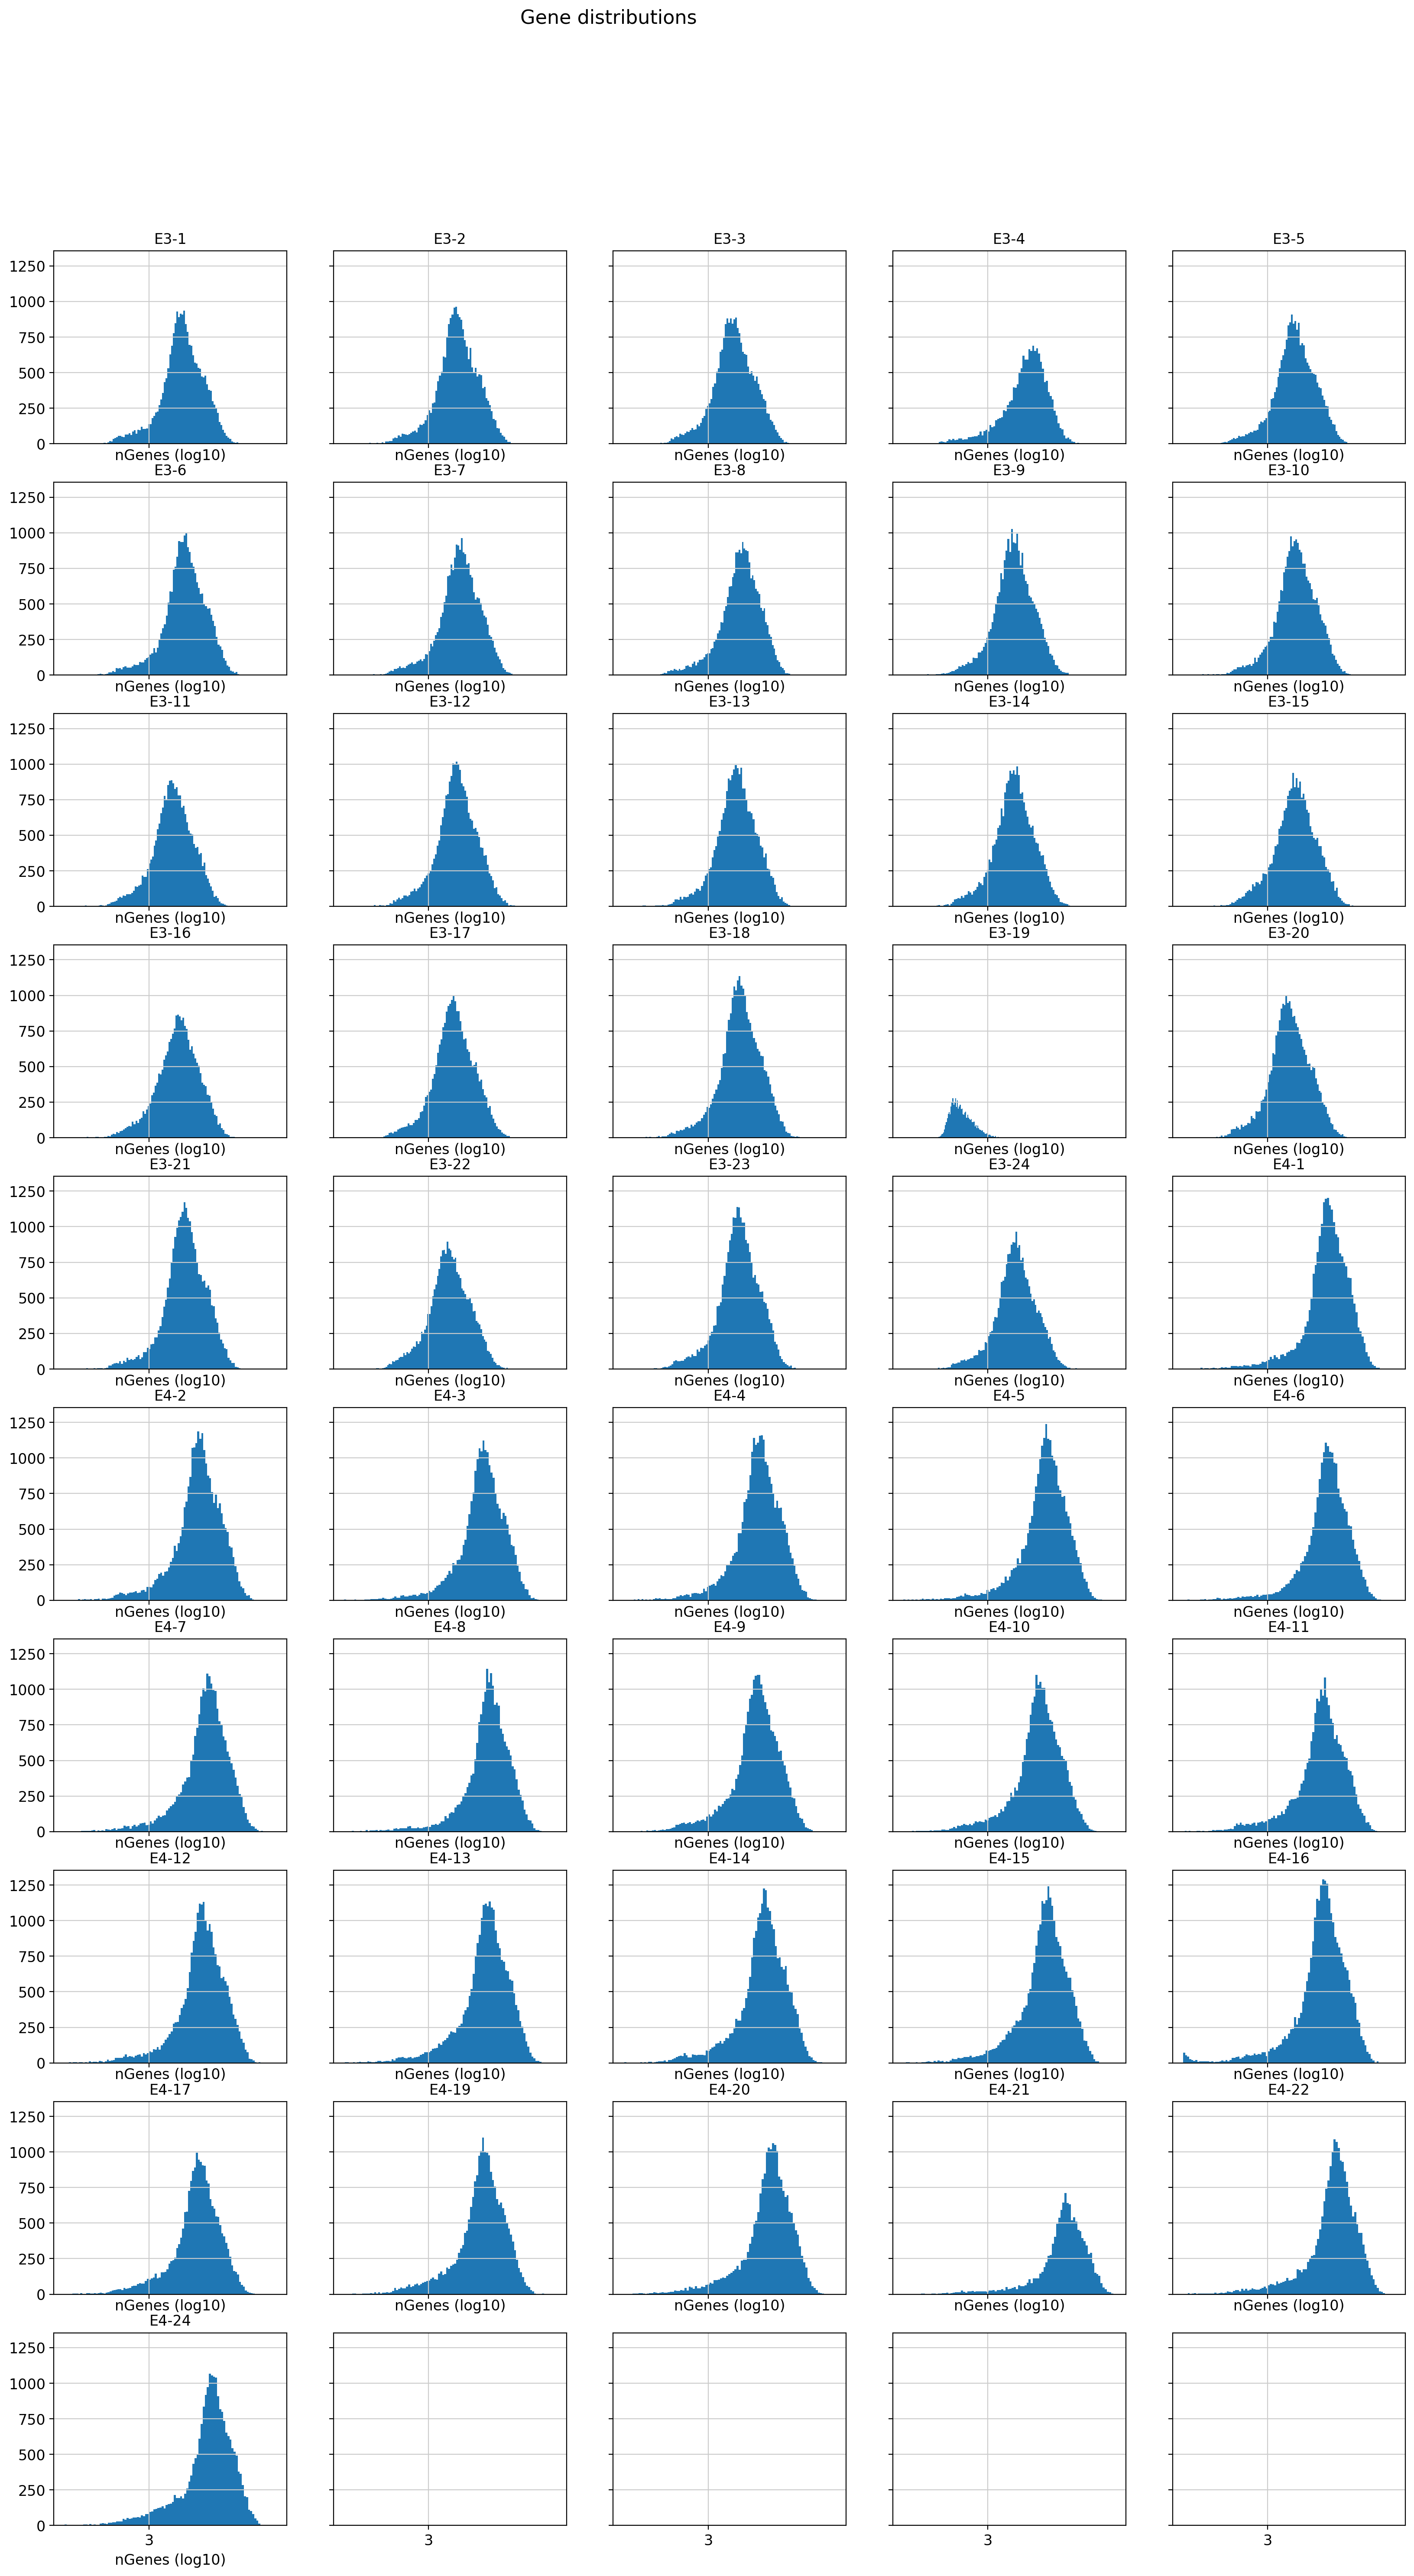

In [13]:
f, axs = plt.subplots(conf_plotting_n_rows, conf_plotting_n_cols,
                      figsize=(conf_plotting_width,
                               conf_plotting_n_rows*conf_plotting_height_per_row),
                      sharey=True, sharex=True)
axs = axs.flatten()

for sample, ad, ax in tqdm(list(zip(conf_samples.keys(), conf_samples.values(), axs))):
    ax.scatter(ad.obs.n_umis.values+1,
               ad.obs.n_genes.values+1,
               alpha=0.5,
               s=0.1)
    ax.axvline(par_empty_drops_ignore_cutoff, color='red')
    ax.axvline(par_empty_drops_lower_umi_cutoff, color='red')

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title(sample)

    ax.set_xlabel('nUMIs')
    ax.set_ylabel('nGenes')


f.suptitle('UMIs vs genes', fontsize=16)
plt.subplots_adjust(top=0.9)

## UMI distr.

f, axs = plt.subplots(conf_plotting_n_rows, conf_plotting_n_cols,
                      figsize=(conf_plotting_width,
                               conf_plotting_n_rows*conf_plotting_height_per_row),
                      sharey=True, sharex=True)
axs = axs.flatten()

for sample, ad, ax in tqdm(list(zip(conf_samples.keys(), conf_samples.values(), axs))):
    ax.hist(ad.obs.log10_n_umis.values, bins=100)
    ax.axvline(np.log10(par_empty_drops_ignore_cutoff), color='red')
    ax.axvline(np.log10(par_empty_drops_lower_umi_cutoff), color='red')

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_title(sample)
    ax.set_xlabel('nUMIs (log10)')

f.suptitle('UMI distributions', fontsize=16)
plt.subplots_adjust(top=0.9)

## Gene distr.

f, axs = plt.subplots(conf_plotting_n_rows, conf_plotting_n_cols,
                      figsize=(conf_plotting_width,
                               conf_plotting_n_rows*conf_plotting_height_per_row),
                      sharey=True, sharex=True)
axs = axs.flatten()

for sample, ad, ax in tqdm(list(zip(conf_samples.keys(), conf_samples.values(), axs))):
    ax.hist(ad.obs.log10_n_genes.values, bins=100)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_title(sample)
    ax.set_xlabel('nGenes (log10)')

f.suptitle('Gene distributions', fontsize=16)
plt.subplots_adjust(top=0.9)

## nGenes vs nUMIs and distributions (with EmptyDrops)

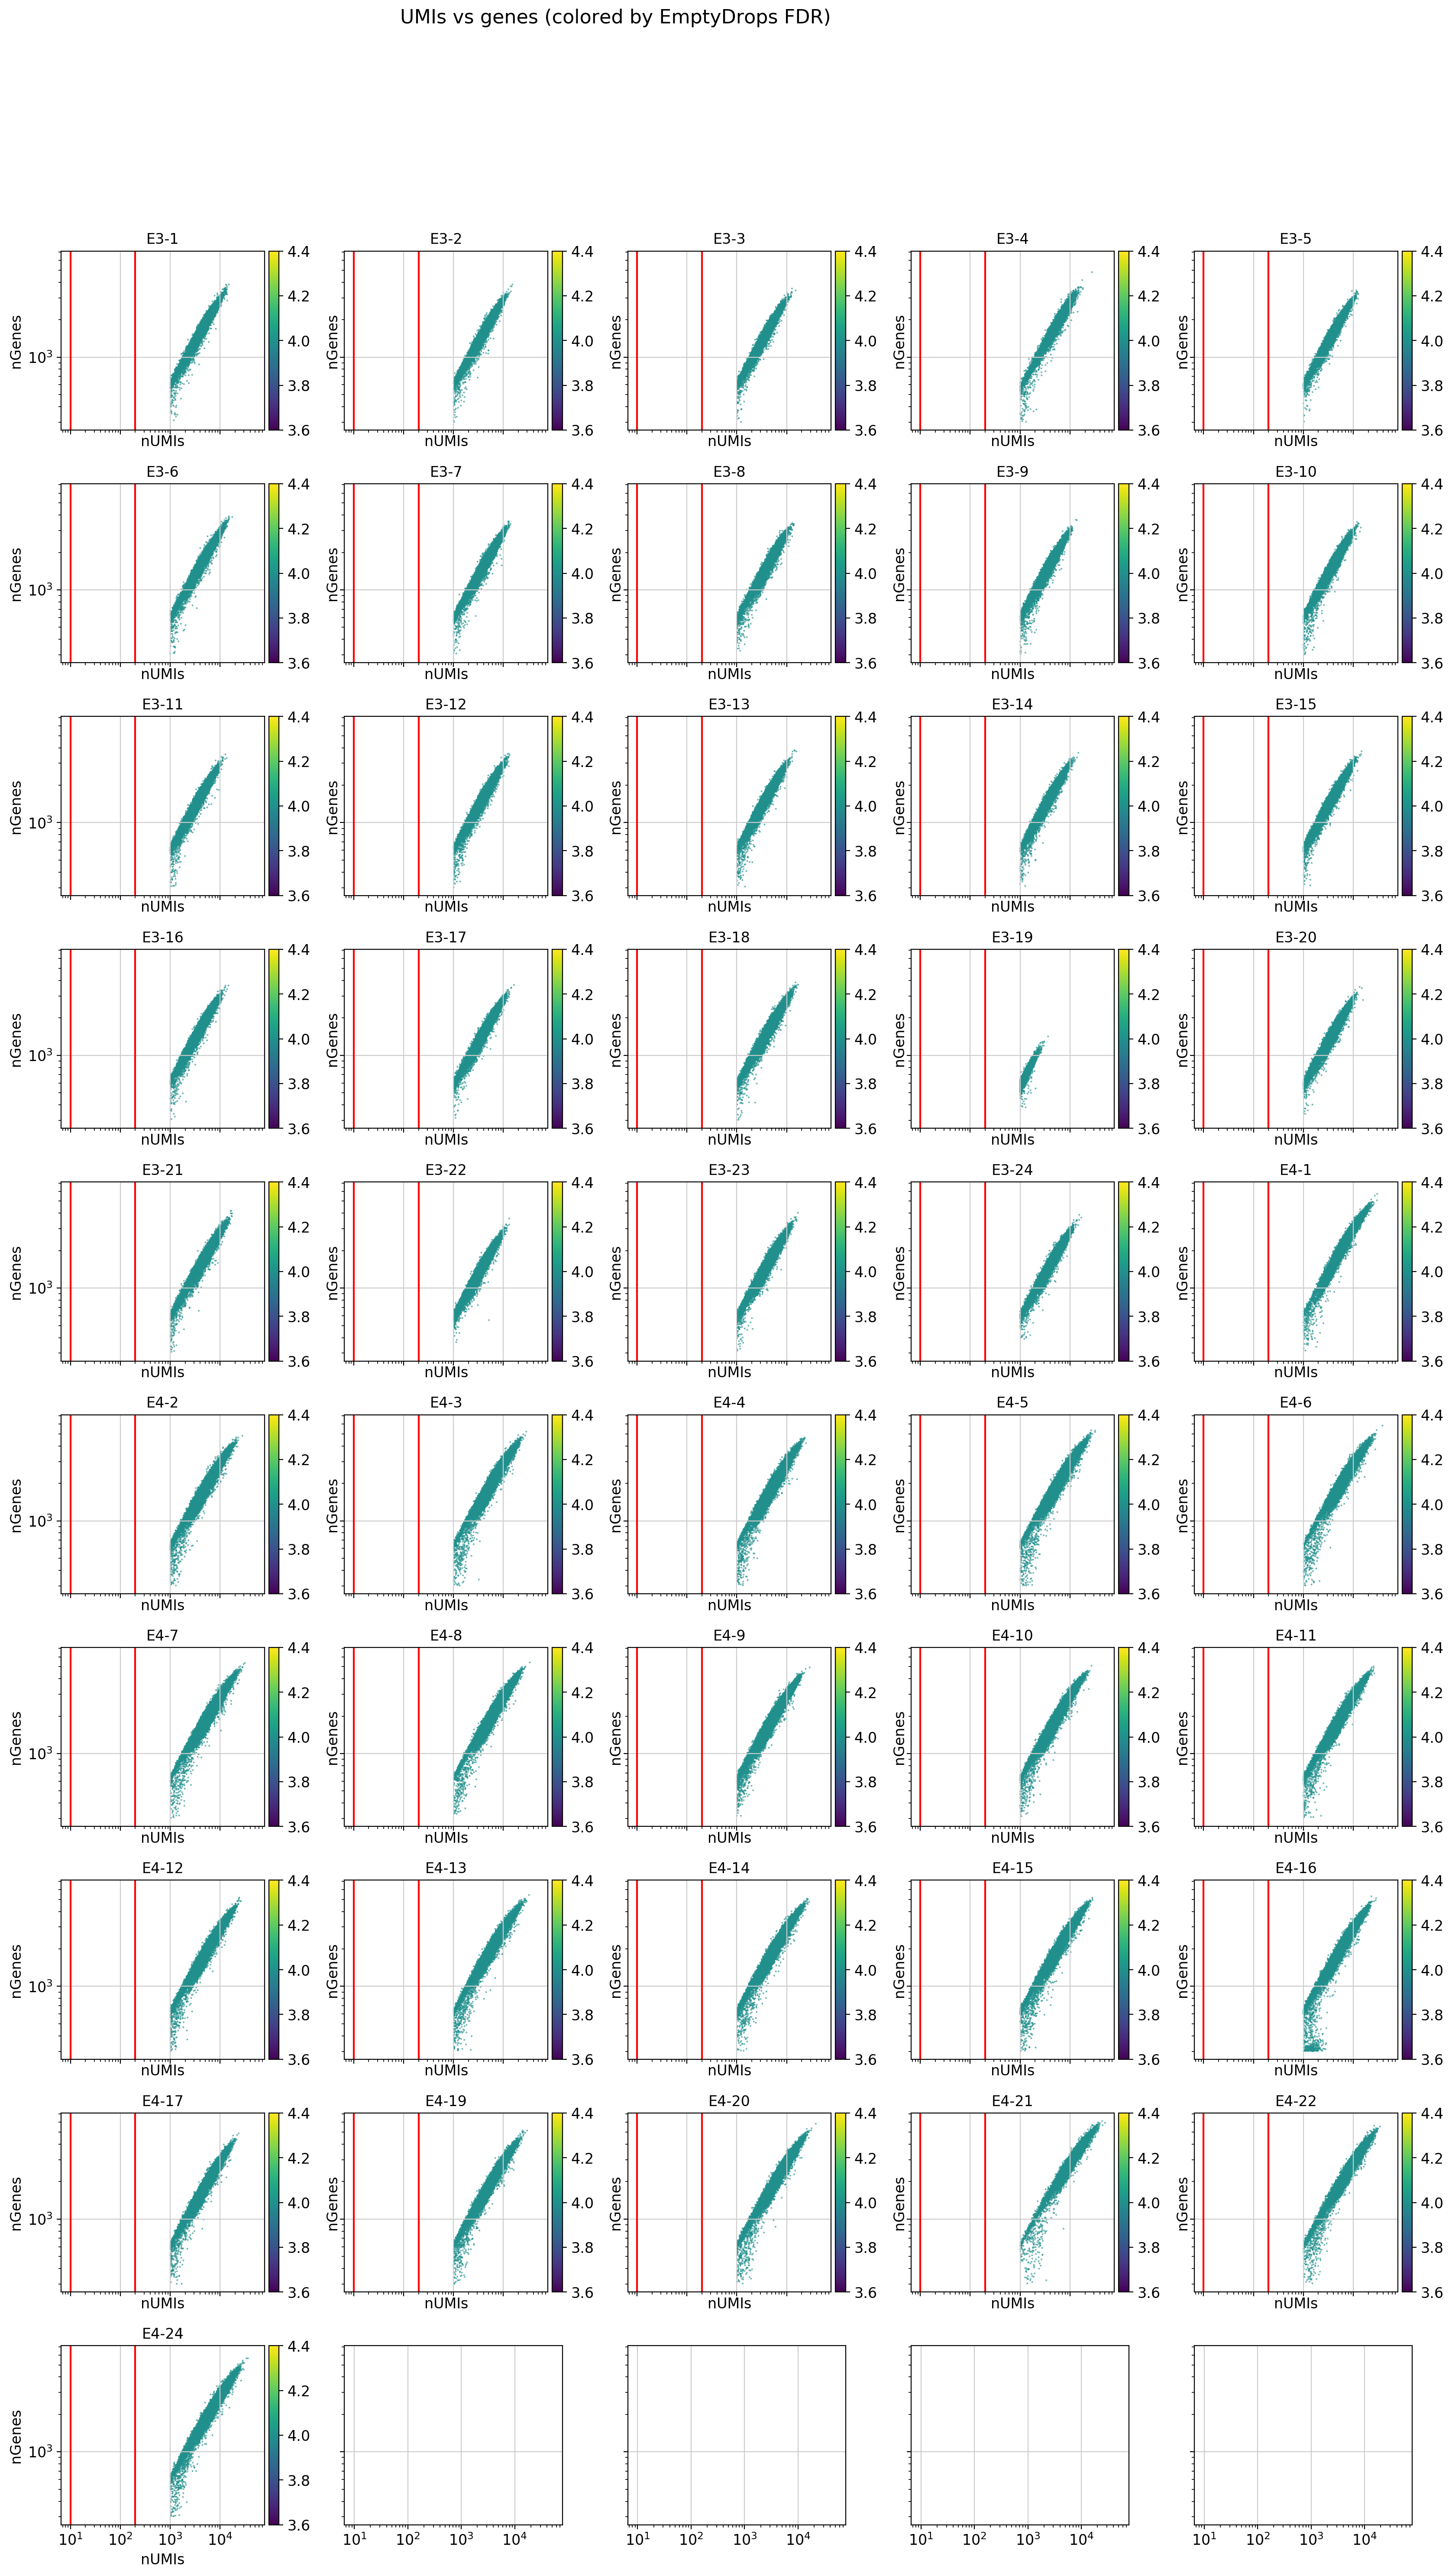

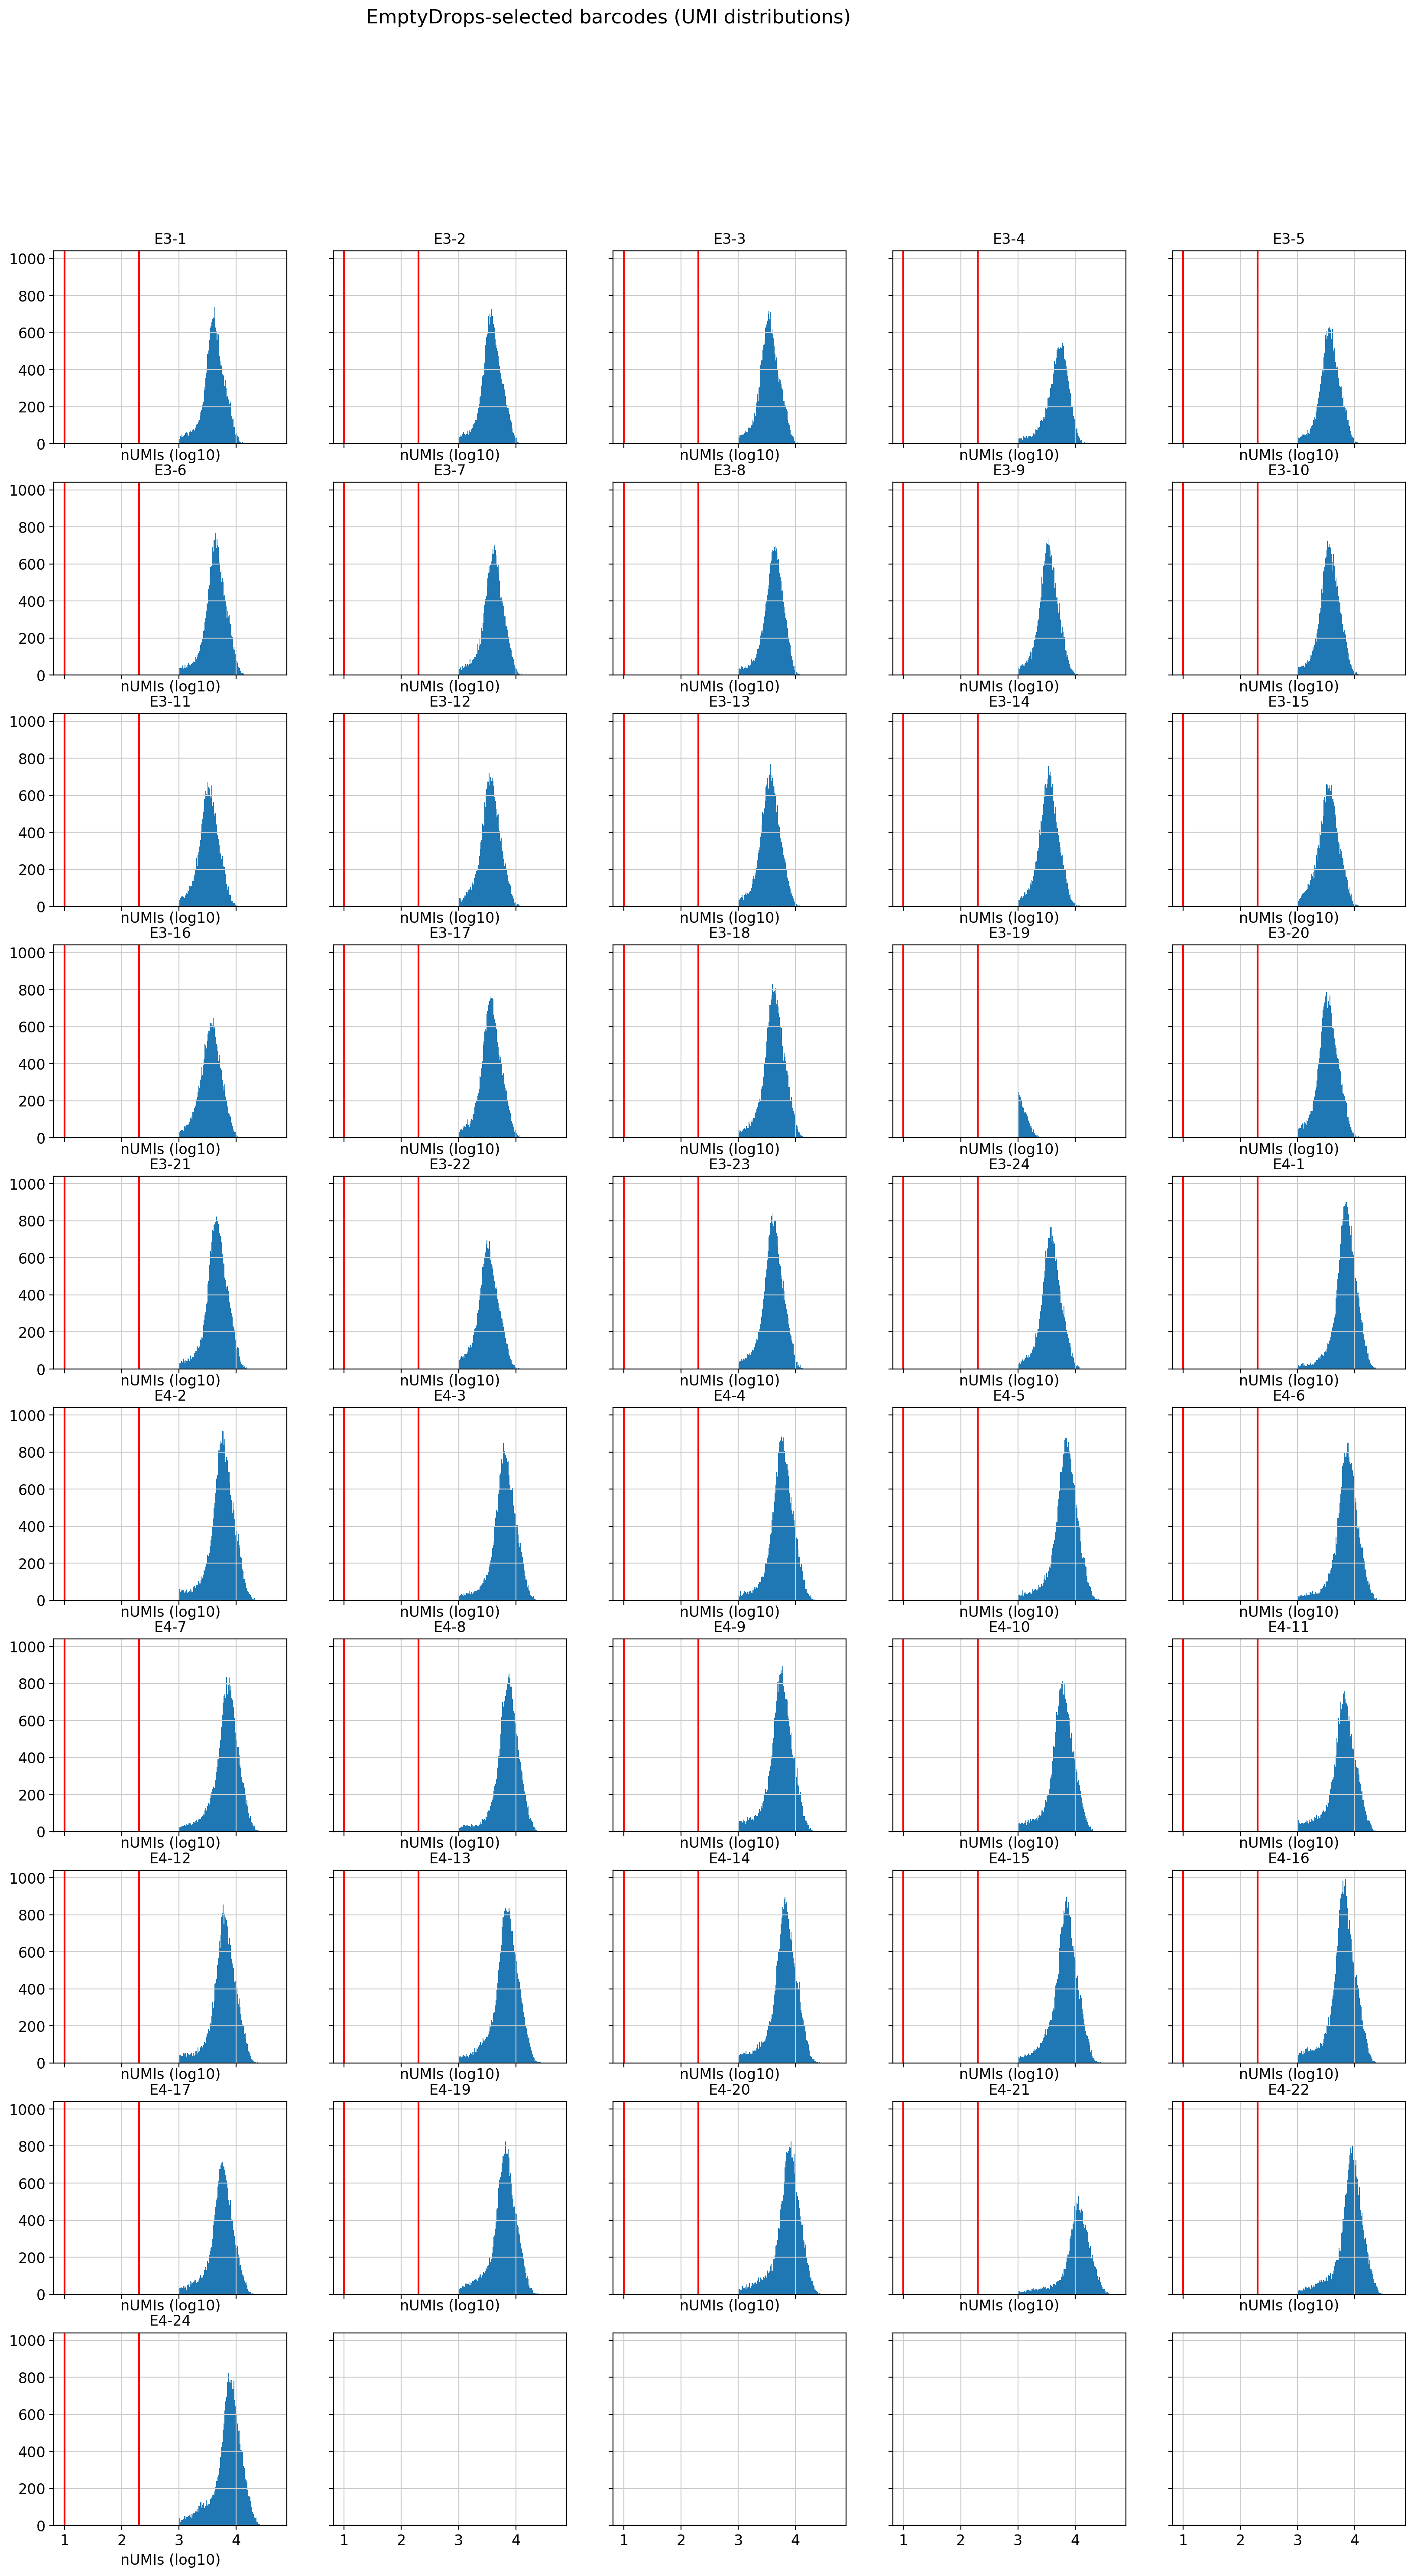

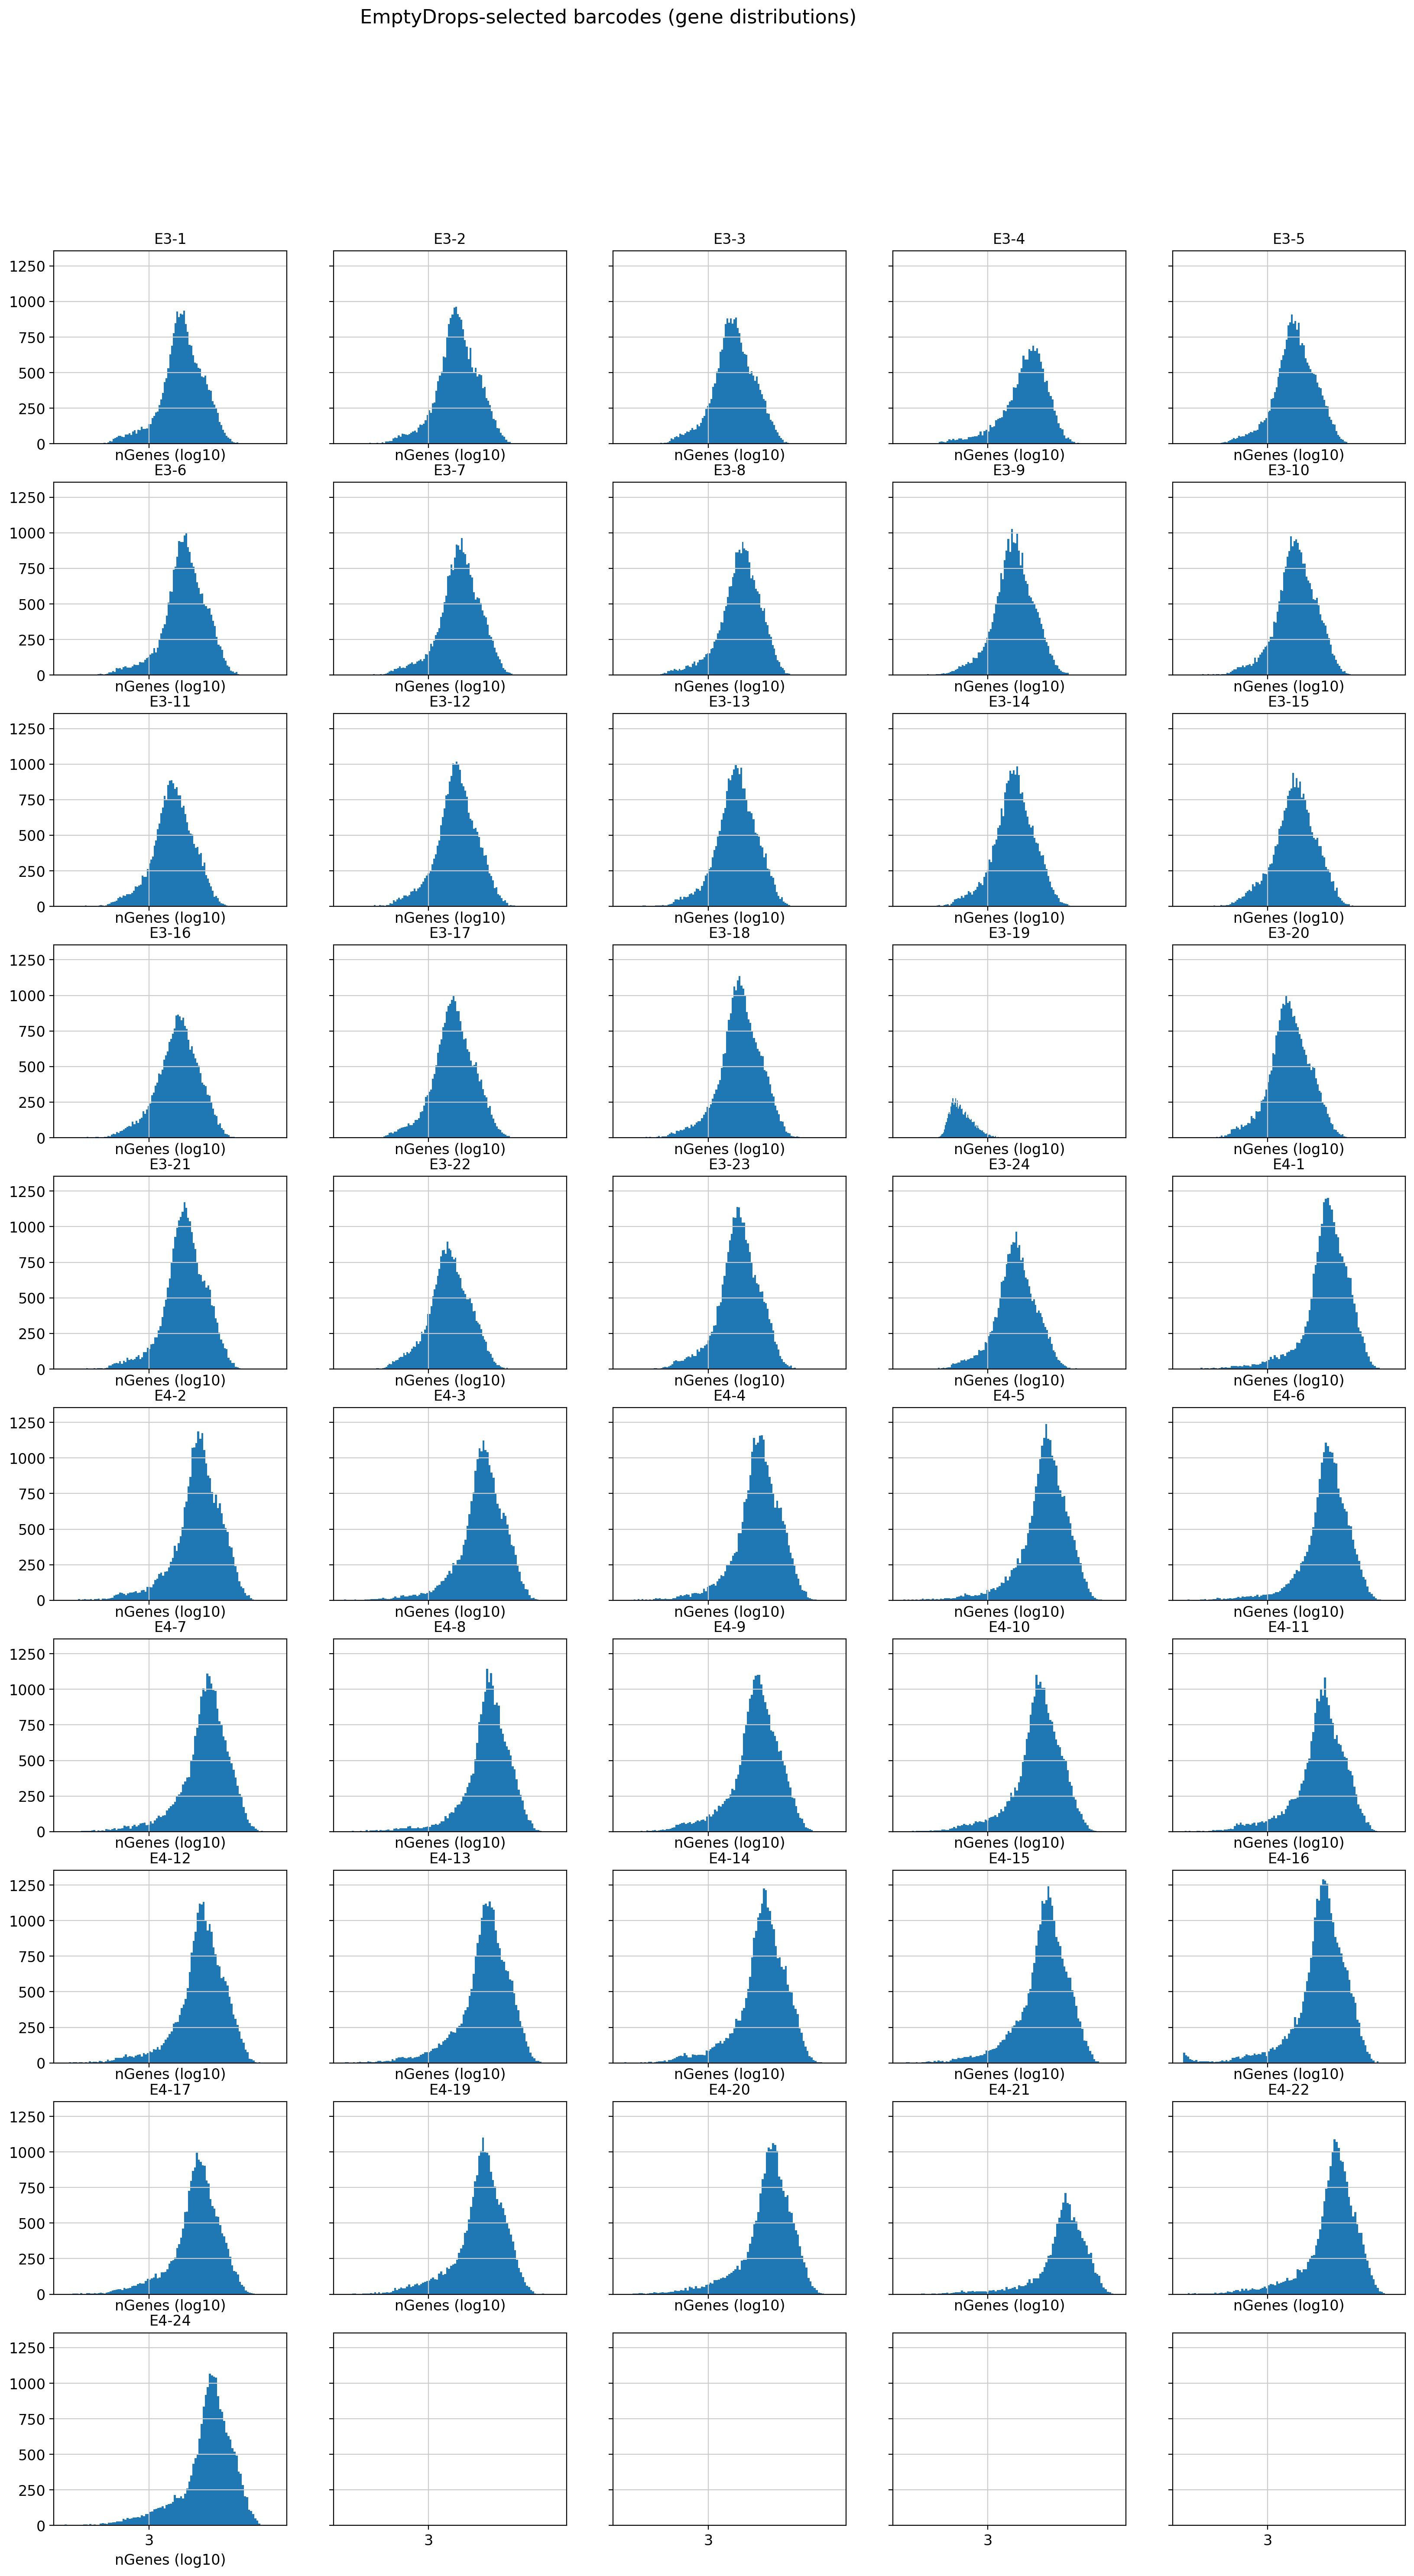

In [14]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

if (conf_sample_sheet.raw.astype(str).str.lower() == 'true').any():

    f, axs = plt.subplots(conf_plotting_n_rows, conf_plotting_n_cols,
                          figsize=(conf_plotting_width,
                                   conf_plotting_n_rows*conf_plotting_height_per_row),
                          sharey=True, sharex=True)
    axs = axs.flatten()

    for sample, ad, ax in tqdm(list(zip(conf_samples.keys(), conf_samples.values(), axs))):
        if np.any(np.isfinite(ad.obs.neg_log10_empty_drops_FDR)):
            idx = np.argsort(ad.obs.neg_log10_empty_drops_FDR)[::-1]
            ad = ad[idx]

            pc = ax.scatter(ad.obs.n_umis.values+1,
                            ad.obs.n_genes.values+1,
                            s=0.1,
                            c=ad.obs.neg_log10_empty_drops_FDR)
            ax.axvline(par_empty_drops_ignore_cutoff, color='red')
            ax.axvline(par_empty_drops_lower_umi_cutoff, color='red')

            ax.set_yscale('log')
            ax.set_xscale('log')
            ax.set_title(sample)

            ax.set_xlabel('nUMIs')
            ax.set_ylabel('nGenes')

            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.05)
            f.colorbar(pc, cax=cax, orientation='vertical')

    f.suptitle('UMIs vs genes (colored by EmptyDrops FDR)', fontsize=16)
    plt.subplots_adjust(wspace=0.3, hspace=0.3, top=0.9)

    ## UMI distr.

    f, axs = plt.subplots(conf_plotting_n_rows, conf_plotting_n_cols,
                          figsize=(conf_plotting_width,
                                   conf_plotting_n_rows*conf_plotting_height_per_row),
                          sharey=True, sharex=True)
    axs = axs.flatten()

    for sample, ad, ax in tqdm(list(zip(conf_samples.keys(), conf_samples.values(), axs))):
        if np.any(np.isfinite(ad.obs.neg_log10_empty_drops_FDR)):
            ad = ad[ad.obs.neg_log10_empty_drops_FDR > -np.log10(par_empty_drops_fdr_cutoff)]
            ax.hist(ad.obs.log10_n_umis.values, bins=100)
            ax.axvline(np.log10(par_empty_drops_ignore_cutoff), color='red')
            ax.axvline(np.log10(par_empty_drops_lower_umi_cutoff), color='red')

            ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
            ax.set_title(sample)
            ax.set_xlabel('nUMIs (log10)')

    f.suptitle('EmptyDrops-selected barcodes (UMI distributions)', fontsize=16)
    plt.subplots_adjust(top=0.9)

    # Gene distr.

    f, axs = plt.subplots(conf_plotting_n_rows, conf_plotting_n_cols,
                          figsize=(conf_plotting_width,
                                   conf_plotting_n_rows*conf_plotting_height_per_row),
                          sharey=True, sharex=True)
    axs = axs.flatten()

    for sample, ad, ax in tqdm(list(zip(conf_samples.keys(), conf_samples.values(), axs))):
        if np.any(np.isfinite(ad.obs.neg_log10_empty_drops_FDR)):
            ad = ad[ad.obs.neg_log10_empty_drops_FDR > -np.log10(par_empty_drops_fdr_cutoff)]
            x = ad.obs.log10_n_genes.values
            ax.hist(x, bins=100)

            ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
            ax.set_title(sample)
            ax.set_xlabel('nGenes (log10)')

    f.suptitle('EmptyDrops-selected barcodes (gene distributions)', fontsize=16)
    plt.subplots_adjust(top=0.9)

## Serialize the session

In [15]:
k = None
var = None

with shelve.open('session_01.pkl', protocol=4, flag='n') as db:
    for k, var in globals().items():
        if k.startswith('par_') or k.startswith('conf_'):
            print(f'Storing {k}...')
            db[k] = var
db.close()

Storing par_species...
Storing par_data_dir...
Storing par_initial_umi_cutoff...
Storing par_initial_gene_cutoff...
Storing par_empty_drops_lower_umi_cutoff...
Storing par_empty_drops_ignore_cutoff...
Storing par_empty_drops_niters...
Storing par_empty_drops_fdr_cutoff...
Storing par_empty_drops_retain...
Storing par_cutoff_min_counts...
Storing par_cutoff_min_genes...
Storing par_cutoff_max_genes...
Storing par_final_empty_drops_fdr_cutoff...
Storing par_remove_mito_genes...
Storing par_mito_cutoff...
Storing par_remove_sex_genes...
Storing par_preprocessing_target_sum...
Storing par_regress_out_variables...
Storing par_regress_out_n_jobs...
Storing par_downstream_n_top_genes...
Storing par_downstream_hvg_batch_key...
Storing par_downstream_n_pcs...
Storing par_downstream_n_neighbors...
Storing par_downstream_louvain_resolution...
Storing par_downstream_neighbor_metric...
Storing par_save_filename_sample...
Storing par_save_filename...
Storing par_save_filename_group...
Storing par_re